## Figure 1: Performance of the $p_0$ perturbative algorithm


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

import utils
import response_matrix

In [2]:
# For the distribution, I'm going to use a normal distribution centered at 0000 in the permuted space
# i.e. treat x-values as int_n's that overflow 2^n - 1 -> 0

n = 5
def gaussian(x, x0, sigma):
    return np.exp(-(x - x0)**2 / (2 * sigma**2)) / (np.sqrt(2 * np.pi) * sigma)

def uniform(n):
    return np.ones(1 << n) / (1 << n)

def permuted_nbit_guassian(j, n, sigma):
    """Compute the gaussian centered at n//2 on a bit value `j` that has been shifted by n//2.
    
    This has the effect of centering the gaussian on `0` but maintaining tails symmetrically around
    `000` in both the high- and low-weight subspaces.
    """
    halfpoint = 1 << (n - 1)
    fullrange = 1 << n
    x = ((j + (halfpoint)) % fullrange) / fullrange
    x0 = halfpoint / fullrange
    out = gaussian(x, x0, sigma)
    return out / sum(out)
    
    
def nbit_guassian(j, n, sigma):
    """Compute the asymmetric gaussian centered at 0.
    """
    fullrange = 1 << n
    x = j / fullrange
    x0 = 0
    out = gaussian(x, x0, sigma)
    return out / sum(out)
    
# permuted_nbit_guassian(0, 4, .25)

# gaussian(0, 0, .25)

1.0000000000000002


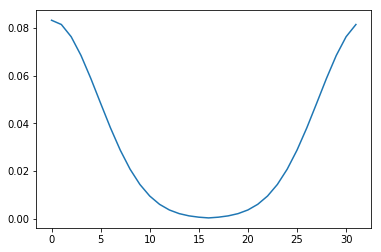

In [3]:
x = np.arange(1 << n)
p0 = permuted_nbit_guassian(x, n, .15) 
plt.plot(x, p0)
print(sum(p0))

0.9999999999999999


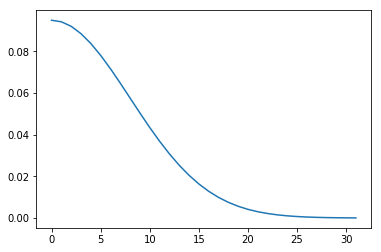

In [4]:
x = np.arange(1 << n)
p0 = nbit_guassian(x, n, .25)
plt.plot(x, p0)
print(sum(p0))

1.0


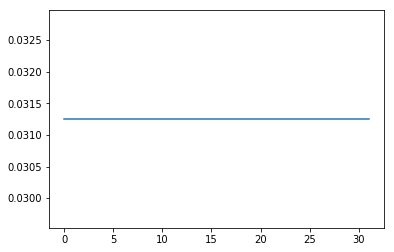

In [5]:
x = np.arange(1 << n)
p0 = uniform(n)
plt.plot(x, p0)
print(sum(p0))

### Compute the corrected prob distribution using Algorithm 1

### Construct test R

We enforce that $R$ has a tensor structure so that multi-flip events are necessarily exponentially suppressed in weight change of bitstring.

In [6]:

q01_arr = np.asarray([0.09, .07, 0.12, 0.08, 0.11, 0.06, 0.07, 0.11, 0.05, 0.08])
q10_arr = np.asarray([0.04, .03, .05, 0.04, 0.03, .05, .04, 0.06, 0.05, 0.03])
wvals = [1, 2, 3, 4]
nqubits_lst = [6, 8, 10, 12]
# nqubits_lst = [6, 8, 10]
R = response_matrix.Rmatrix(q01_arr, q10_arr)
Rinv = np.linalg.inv(R)

## Compute two different corrections

In [7]:
# comparison = lambda x,y: scipy.stats.entropy(x,y)
def rel_err(x, y): return abs(x - y) / x # x is 'truth'
def abs_err(x, y): return abs(x - y)
comparison = rel_err

nexperiments = 3


# Outcomes for correcting p0
p0_baseline = np.zeros((nexperiments, len(nqubits_lst)))
p0_outcomes = np.zeros((nexperiments, len(wvals), len(nqubits_lst))) # rows correspond to w=1,2...
qfixed = 0.06

for i in range(nexperiments):
    for j, n_qubits in enumerate(nqubits_lst):
        # Generate response matrix and artificial readout error
        R = response_matrix.generate_characteristic_R(qfixed, n_qubits)
        x = np.arange(1 << n_qubits)
        if i == 0:
            p_true = permuted_nbit_guassian(x, n_qubits, .25)
        elif i == 1:
            p_true = nbit_guassian(x, n_qubits, .25)
        elif i == 2:
            p_true = uniform(n_qubits)

    #     p_true = nbit_guassian(x, n_qubits, .25)
        p_prime = R @ p_true

        # Just p0 correction
        p0_baseline[i, j] = comparison(p_true[0], p_prime[0])
        for k, w in enumerate(wvals):
            p0_corr = response_matrix.invert_p0_truncated(R, p_prime, w=w)
            p0_outcomes[i, k, j] = abs(p_true[0] - p0_corr)


## Compute correction on just $p_0$

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


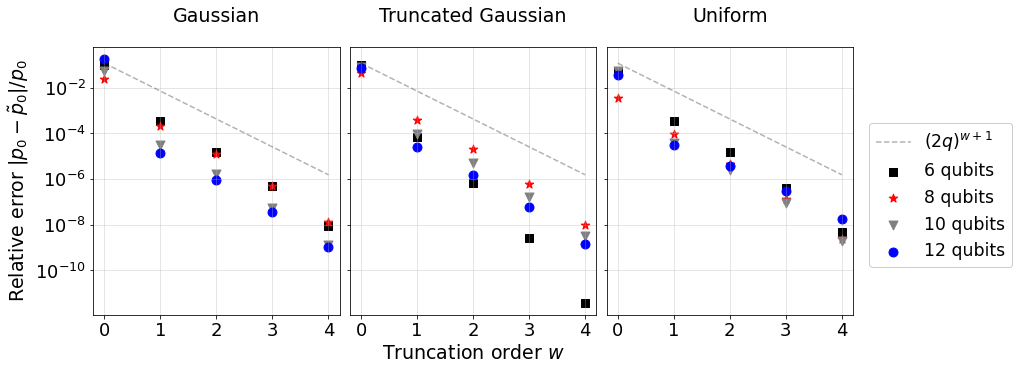

In [8]:
plt.style.use('./style.mplstyle')

fig, axes = plt.subplots(1, nexperiments, figsize=(14, 5), constrained_layout=True, sharey=True)
experiment_labels = [
    
]

for i in range(nexperiments):
    all_p0_outcomes = np.vstack((p0_baseline[i], p0_outcomes[i]))
    x = np.asarray([0] + wvals)
    leglabs = [f"{x} qubits" for x in nqubits_lst]
    markers = ['s', '*', 'v', 'o', 'd']
    colors = ['k', 'r', 'gray', 'b', 'g']


    # p0 results
    for j, y in enumerate(all_p0_outcomes.T):
        # Exclude the _complete_ inversion problem as it messes up the comparison
        axes[i].scatter(x, y, label=leglabs[j], marker=markers[j], c=colors[j], s=80)
    axes[i].plot(x, 2 * qfixed ** (x+1), ls='--', c='k', alpha=0.3, label=r"$(2q)^{w+1}$")
        
axes[0].set_ylabel(r"Relative error $|p_0 - \tilde{p}_0| / p_0$")
axes[1].set_xlabel(r"Truncation order $w$")
axes[2].legend(bbox_to_anchor=(1.03, .75), framealpha=1)

axes[0].set_title("Gaussian")
axes[1].set_title("Truncated Gaussian")
axes[2].set_title("Uniform")

for ax in axes:
    ax.set_xticks(x)
    ax.set_xticklabels(x)
    ax.semilogy()
    ax.grid(True, alpha=0.4)

    # ax.set_ylim(0, ax.get_ylim()[1])

    

fig.savefig("figures/figure1.pdf")

### Modification for PRA (single column)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


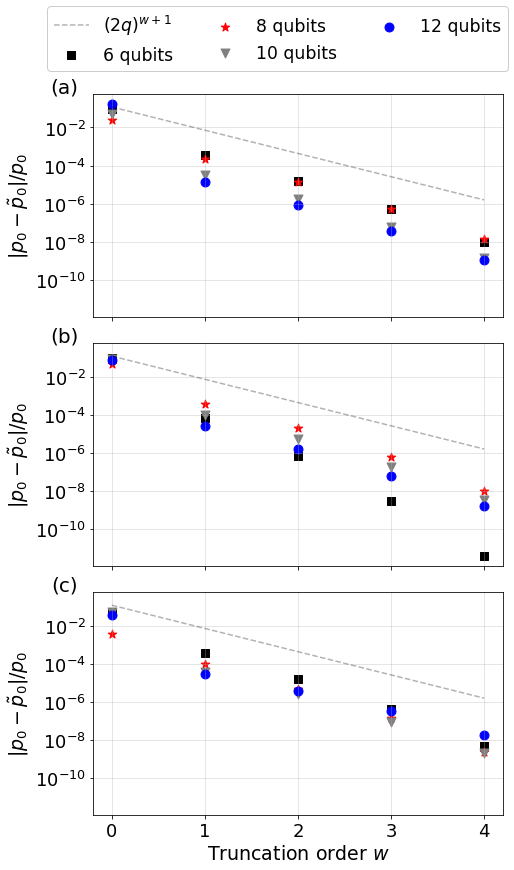

In [34]:
plt.style.use('./style.mplstyle')

fig, axes = plt.subplots(nexperiments, 1, figsize=(7, 12), constrained_layout=True, sharex=True, sharey=True)
experiment_labels = [
    
]

for i in range(nexperiments):
    all_p0_outcomes = np.vstack((p0_baseline[i], p0_outcomes[i]))
    x = np.asarray([0] + wvals)
    leglabs = [f"{x} qubits" for x in nqubits_lst]
    markers = ['s', '*', 'v', 'o', 'd']
    colors = ['k', 'r', 'gray', 'b', 'g']


    # p0 results
    for j, y in enumerate(all_p0_outcomes.T):
        # Exclude the _complete_ inversion problem as it messes up the comparison
        axes[i].scatter(x, y, label=leglabs[j], marker=markers[j], c=colors[j], s=80)
    axes[i].plot(x, 2 * qfixed ** (x+1), ls='--', c='k', alpha=0.3, label=r"$(2q)^{w+1}$")
        
for ax in axes:
    ax.set_ylabel(r"$|p_0 - \tilde{p}_0| / p_0$")
    
axes[-1].set_xlabel(r"Truncation order $w$")
axes[-1].set_xticks(x)
axes[-1].set_xticklabels(x)
axes[0].legend(loc="upper center", bbox_to_anchor=(0.45, 1.43), framealpha=1, ncol=3)

# axes[0].set_title("Gaussian")
# axes[1].set_title("Truncated Gaussian")
# axes[2].set_title("Uniform")

for ax in axes:
    ax.semilogy()
    ax.grid(True, alpha=0.4)

    # ax.set_ylim(0, ax.get_ylim()[1])
    
for ax, lab in zip(axes, ["(a)", "(b)", "(c)"]):
    ax.text(-0.07, 1.03, lab, horizontalalignment='center', verticalalignment='center', size=20, transform=ax.transAxes)

    
# # cAPTION
# ax1.text(-0.1, 1, r"b", horizontalalignment='center', verticalalignment='center', size=24, transform=ax1.transAxes, weight="bold")
# ax2.text(-0.2, 1.54, r"c", horizontalalignment='center', verticalalignment='center', size=24, transform=ax2.transAxes, weight="bold")

    

fig.savefig("figures/figure1_pra.pdf")